In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/'

In [ ]:
import zipfile
with zipfile.ZipFile(directory+'ecg_ppg.zip', 'r') as zip_ref:
    zip_ref.extractall(directory+'ecg_ppg/')

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:20]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape)
    dfs.append(a)
data1 = pd.concat(dfs)

(13795, 9)
(749834, 9)
(368771, 9)
(176841, 9)
(163746, 9)
(3735, 9)
(418936, 9)
(2197624, 9)
(261043, 9)
(736018, 9)
(168070, 9)
(397584, 9)
(149789, 9)
(61073, 9)
(3878512, 9)
(22212, 9)
(162492, 9)
(1647772, 9)
(640693, 9)
(406487, 9)


In [2]:
data_filtered = data1.dropna()
data = data1.dropna()

In [3]:
import warnings
warnings.filterwarnings('ignore')
data_filtered['red_rr'] = data['ppg_rr'].apply(lambda x:x[0])
data_filtered['ir_rr'] = data['ppg_rr'].apply(lambda x:x[1])
data_filtered['green_rr'] = data['ppg_rr'].apply(lambda x:x[2])
data_filtered['red_qual'] = data['likelihood'].apply(lambda x:x[0])
data_filtered['ir_qual'] = data['likelihood'].apply(lambda x:x[1])
data_filtered['green_qual'] = data['likelihood'].apply(lambda x:x[2])

In [4]:
columns = ['red','ir','green']
X = []
for c in columns:
    temp = data_filtered[[c+'_rr',c+'_qual','ecg_rr']].values
    X.append(temp)
X = np.concatenate(X,axis=0)

In [5]:
X = X[X[:,0]>0]

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

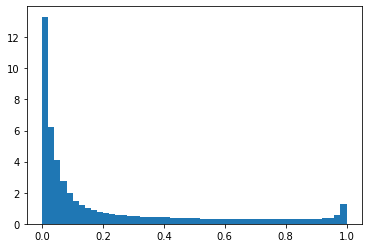

In [7]:

plt.figure()
plt.hist(X[:,1],50,normed=True)
plt.show()
# X

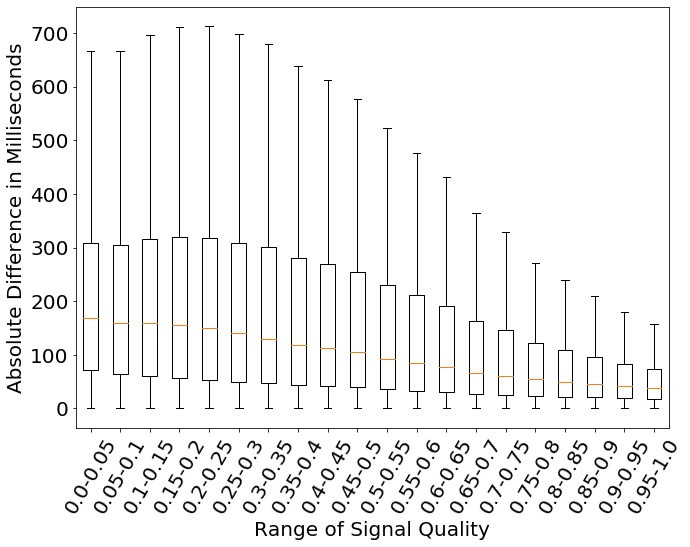

In [8]:
l_range = np.arange(0,1,.05)
x = []
y = []
for l in l_range:
    index = np.where((X[:,1]>=l)&(X[:,1]<l+.05))[0]
    temp = X[index]
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,0]-temp[:,2])))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
plt.boxplot(y,showfliers=False)
plt.xticks(range(1,len(x)+1),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [9]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed


from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [10]:
data_all.dropna().shape,data_all.shape

((1065272, 18), (12625027, 18))

In [12]:
unique_users = data_all['user'].unique()

def get_data(name,df):
#     df = df.fillna(df.mean())
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
all_X = []
for user in unique_users:
    data_user = data_all[data_all.user.isin([user])]
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        continue
    df_col = Parallel(n_jobs=20,verbose=1)(delayed(get_data)(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60)
#     df_col = [get_data(group_name, df_group) for group_name, df_group
#                                            in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    all_X.append(np.concatenate(df_col))
        

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 241 out of 241 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.1s
[Parallel(n_jobs=20)]: Done 19305 out of 19305 | elapsed:   13.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5

In [13]:
print(data_all.columns.values)

['window' 'timestamp' 'likelihood' 'ppg_rr' 'activity' 'ecg_rr' 'time'
 'version' 'user' 'red_rr' 'ir_rr' 'green_rr' 'red_qual' 'ir_qual'
 'green_qual' 'index' 'ppg_rr_best' 'likelihood_best']


In [14]:
X = np.concatenate(all_X)

In [15]:
X.shape

(231530, 60, 11)

In [16]:
import pickle
pickle.dump(X,open('../data/60_second_data1.p','wb'))

In [ ]:
data_resampled['activity'].shape

In [ ]:
data_resampled['activity'].dropna().shape

In [ ]:
X.shape

In [ ]:
!conda install statsmodels